# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation is be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the product with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it is obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Data cleaning for all the reviews 
from bs4 import BeautifulSoup

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)           #remove urls
    sentence = BeautifulSoup(sentence, 'lxml').get_text() #remove xml tags
    sentence = decontracted(sentence)                     
    sentence = re.sub("\S*\d\S*", "", sentence).strip()   #remove words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)        #remove special characters
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3471.23it/s]


In [14]:
preprocessed_reviews[0]

'product available victor traps unreal course total fly genocide pretty stinky right nearby'

In [15]:
len(preprocessed_reviews)

4986

# [3] Featurization


# import embedding


In [16]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:

    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
label = final['Score']

In [18]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D

Using TensorFlow backend.


In [19]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(preprocessed_reviews)
vocab_size = len(t.word_index) + 1

In [20]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(preprocessed_reviews)

In [21]:
# pad documents to a max length of max words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [22]:
padded_docs[1500]

array([ 598,  122,   63,   63,  741,  178,    6, 1346,   15,  464,  256,
        891,  606,  117, 1404, 1215,  178, 2636,    3, 1455, 6328,  217,
        261,  256,   36,  536,  117,    1,    2,  701,    1,   58,  391,
        354,   27, 2196,  206,   69,   16,  536,  784, 6329,  302,   36,
          9,  550,  354,  784,  179,  391,  761,  333,   24,  577,   71,
       5004,  539,  646,  343,  811,  117, 1194,    1,  606,  117, 9153,
          8,   79,  606,  315,  811, 1432,    2,  538,  354, 1236,  141,
          1,  168,    5,    2,  538,  354, 1236,  343,  141, 4826,  507,
        481,  541,  343,  117,  961,    1, 1054,  845,    8,   70,  341,
        653, 1692,   36,  199,  117,  961,  831,   53,   91,   97,  118,
        561,  760, 9154,  478, 3969,   91,  354,  343,  811,   71,    2,
        701,   36,  536,   84,   32,  461,  389,   58,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [23]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# [4] Prepare Model

In [24]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, label, test_size=0.2, random_state=42)

## [4.1] Deep Neural Net

In [25]:
# DNN with embeddings

vocab_size = vocab_size

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dense(16, activation=tf.nn.relu) )
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           650800    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 655,121
Trainable params: 655,121
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=50, batch_size=256)

Train on 3988 samples, validate on 998 samples
Epoch 1/50
3988/3988 [==============================] - 1s 367us/step - loss: 0.6347 - acc: 0.8350 - val_loss: 0.5671 - val_acc: 0.8437
Epoch 2/50
3988/3988 [==============================] - 0s 23us/step - loss: 0.5292 - acc: 0.8365 - val_loss: 0.4722 - val_acc: 0.8437
Epoch 3/50
3988/3988 [==============================] - 0s 23us/step - loss: 0.4753 - acc: 0.8365 - val_loss: 0.4460 - val_acc: 0.8437
Epoch 4/50
3988/3988 [==============================] - 0s 23us/step - loss: 0.4528 - acc: 0.8365 - val_loss: 0.4289 - val_acc: 0.8437
Epoch 5/50
3988/3988 [==============================] - 0s 24us/step - loss: 0.4313 - acc: 0.8365 - val_loss: 0.4169 - val_acc: 0.8437
Epoch 6/50
3988/3988 [==============================] - 0s 22us/step - loss: 0.4117 - acc: 0.8370 - val_loss: 0.4109 - val_acc: 0.8417
Epoch 7/50
3988/3988 [==============================] - 0s 22us/step - loss: 0.3994 - acc: 0.8410 - val_loss: 0.4031 - val_acc: 0.8397
Epoch 8

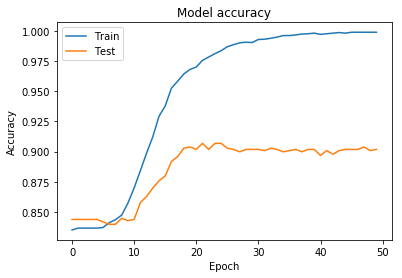

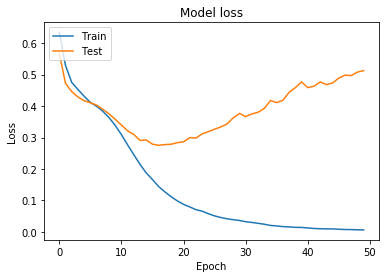

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## [4.2] LSTM Model

In [29]:
vocab_size = vocab_size
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=False))
model_lstm.add(keras.layers.CuDNNLSTM((128),  return_sequences=True))
model_lstm.add(keras.layers.CuDNNLSTM((64),  return_sequences=False))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

In [30]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           650800    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 150, 128)          92160     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 792,689
Trainable params: 141,889
Non-trainable params: 650,800
_________________________________________________________________


In [32]:
history = model_lstm.fit(X_train,y_train, epochs=50, validation_data=(X_test,y_test), batch_size=256)

Train on 3988 samples, validate on 998 samples
Epoch 1/50
3988/3988 [==============================] - 3s 630us/step - loss: 0.5358 - acc: 0.7921 - val_loss: 0.4430 - val_acc: 0.8437
Epoch 2/50
3988/3988 [==============================] - 1s 189us/step - loss: 0.4468 - acc: 0.8368 - val_loss: 0.4410 - val_acc: 0.8397
Epoch 3/50
3988/3988 [==============================] - 1s 197us/step - loss: 0.4433 - acc: 0.8365 - val_loss: 0.4361 - val_acc: 0.8437
Epoch 4/50
3988/3988 [==============================] - 1s 199us/step - loss: 0.4444 - acc: 0.8368 - val_loss: 0.4358 - val_acc: 0.8437
Epoch 5/50
3988/3988 [==============================] - 1s 194us/step - loss: 0.4426 - acc: 0.8375 - val_loss: 0.4394 - val_acc: 0.8417
Epoch 6/50
3988/3988 [==============================] - 1s 187us/step - loss: 0.4427 - acc: 0.8373 - val_loss: 0.4383 - val_acc: 0.8417
Epoch 7/50
3988/3988 [==============================] - 1s 187us/step - loss: 0.4416 - acc: 0.8383 - val_loss: 0.4343 - val_acc: 0.8437
E

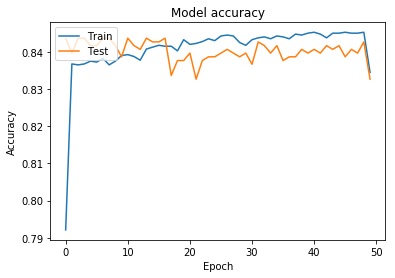

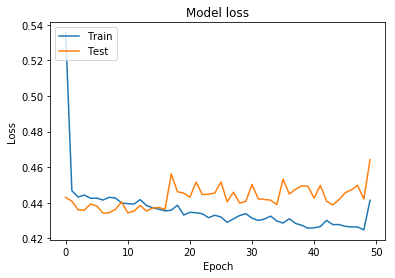

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()